In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

#n = len(np.arange(0, 1, 0.05))
#K = np.zeros((125 * 125))
#iterr = 0

def MAP_Elite(n_legs):
   
    P2 = np.zeros((5**(int(n_legs/2)), 5**(int(n_legs/2))))

    P = P2
    C = np.zeros((5**(int(n_legs/2)), 5**(int(n_legs/2))))
    
    #There are 6 parameters for each leg (i1 , i2 , i1 , i2 , i1 ,i2 ), 
    #therefore each controller is fully described by 36 parameters.
    # Each parameter can have one of these possible values: 0, 0.05, 0.1, ... 0.95, 1.

    for i in range(1, 10000):
        stop = 0
        #iterr += i
        if (i < 40):
            c_prim = random_controller_v2()
        else:
            c = random_selec(C)
            c_prim = random_var_v2(c)
        #for j in range(125*125):
     #       if(K[j] == c_prim and stop == 0):
      #          stop = 1
        if(stop == 0):
            X = behaviour_descr(simulation(c_prim))
            x_prim_leg_1, x_prim_leg_2 = int(X[0]), int(X[1]) 
            p_prim = performance(simulation(c_prim))
            #print(int(x_prim_leg_1))
            if(P[x_prim_leg_1][x_prim_leg_2] < p_prim):
                P[x_prim_leg_1][x_prim_leg_2] = p_prim  
                C[x_prim_leg_1][x_prim_leg_2] = c_prim
        #heat_map = sns.heatmap(Perf, cmap="YlGnBu")
    
    return P, C


def random_controller():
    rand_array = np.arange(0, 1, 0.05)
    controller = np.zeros((5 * 5 * 5, 5 * 5 * 5))
    proba = np.empty(rand_array.size)
    proba.fill(0.05)    
    for i in range(6): #number of legs
        seq = np.random.choice(rand_array, 6, replace = False, p = proba)
        for j in range(6): #number of controllers
            controller[j][i] = seq[j]
    return controller

def random_controller_v2():

    n = len(np.arange(0, 1, 0.05))
    X_controller = random.randint(0, n**24)   #with only 4 parameters (2 DOF)

    return X_controller

def random_selec(C):
    selected_controller = C[np.random.choice(np.arange(0, len(C[0]) - 1))][np.random.choice(np.arange(0, len(C[0]) - 1))]
    return selected_controller

def random_var(control):
    index = np.random.rand([0, len(contr) - 1])
    for i in range(len(control)):
        if(index + 1 < len(contr)):
            control[i][index], control[i][index + 1] = control[i][index + 1], control[i][index] 
        else :
            control[i][index], control[i][index - 1] = control[i][index - 1], control[i][index] 
    return control

def random_var_v2(control):
    n = len(np.arange(0, 1, 0.05))
    
    index = np.random.choice(np.arange(0, 125))
    rand_array = np.arange(0, 1, 0.05)

    proba = np.empty(rand_array.size)
    proba.fill(0.05)
    change = np.random.choice(rand_array, 1, p=proba)
    if(control < n**24 - n**2) :
        control += (change*100)**2
    else :
        control -= (change*100)**2
    return control

def simulation(c_prim):   # simulation of mouvement with chosen controller of 4 parameters for each leg
    
    T = 1000 #secondes, simulation time
    contact = [0, 1]
    legs = 6
    on_ground = np.zeros((T,legs))
    
    for i in range(legs):
        r = np.random.choice(np.arange(0, 3, 0.5))
        k = np.random.choice(np.arange(0, 1, 0.5))
        p = np.random.exponential(size=1000)   #exponential distribution
        p_norm = k * np.random.randn(1000) + r
        if (c_prim % 3 == 0):
            for j in range(T):
                r = np.random.choice(np.arange(0, 1, 0.5))
                    #on_ground[j][i] = np.random.choice(contact, 1, replace=True, p = [0.05, 0.95])
                if(p[j] > p_norm[j]):
                    on_ground[j][i] = 1
                else :
                    on_ground[j][i] = 0
        elif (c_prim % 5 == 0):
            for j in range(T):
                r = np.random.choice(np.arange(0, 1, 0.5))
                    #on_ground[j][i] = np.random.choice(contact, 1, replace=True, p = [0.05, 0.95])
                if(p[j] > 2*p_norm[j]):
                    on_ground[j][i] = 0
                else :
                    on_ground[j][i] = 1
        else :
            for j in range(T):
                r = np.random.choice(np.arange(0, 1, 0.5))
                    #on_ground[j][i] = np.random.choice(contact, 1, replace=True, p = [0.05, 0.95])
                if(p[j] > p_norm[j]):
                    on_ground[j][i] = 0
                else :
                    on_ground[j][i] = 1
            
    #K[iterr] = c_prim
    
    return on_ground

def behaviour_descr(on_ground):    # Proportion of time of each leg on the ground
    # 1 : contact
    # 0 : no contact
    # The result is 6 Boolean time series (Ci for the ith leg).
    legs = len(on_ground[1])
    x_leg = np.zeros(legs)
    X = np.zeros(2)    # coordinate we are looking for
    T = 1000   
    for j in range(legs):
        for i in range(T):
            x_leg[j] += on_ground[i][j]

    x_leg /= 1000
    
    for j in range(legs):
        #x_leg[j] = np.round(x_leg[j], 2)
        if(x_leg[j] < 0.10):
            x_leg[j] = 0
            #k = 0
        elif(x_leg[j] < 0.35):
            x_leg[j] = 0.25
            #k = 1
        elif(x_leg[j] < 0.65):
            x_leg[j] = 0.50
        elif(x_leg[j] < 0.85):
            x_leg[j] = 0.75
        else :
            x_leg[j] = 1.0
            
    X[0] = 100*x_leg[0] + 5*(4*x_leg[2]) + 4*x_leg[4]
    X[1] = 100*x_leg[1] + 5*(4*x_leg[3]) + 4*x_leg[5]  
    
    return X

def performance(on_ground):
    summ = 0

    performances_high = np.arange(5, 15, 0.5)
    performances_low = np.arange(1, 3, 0.5)
    
    for j in range(len(on_ground[1])):
        for i in range(len(on_ground)):
            summ += on_ground[i][j]
        if(summ < int(len(on_ground)/3)):
            perf = np.random.choice(performances_low)
        else:
            perf = np.random.choice(performances_high)
    
    return perf

In [67]:
Perf = MAP_Elite(6)[0]

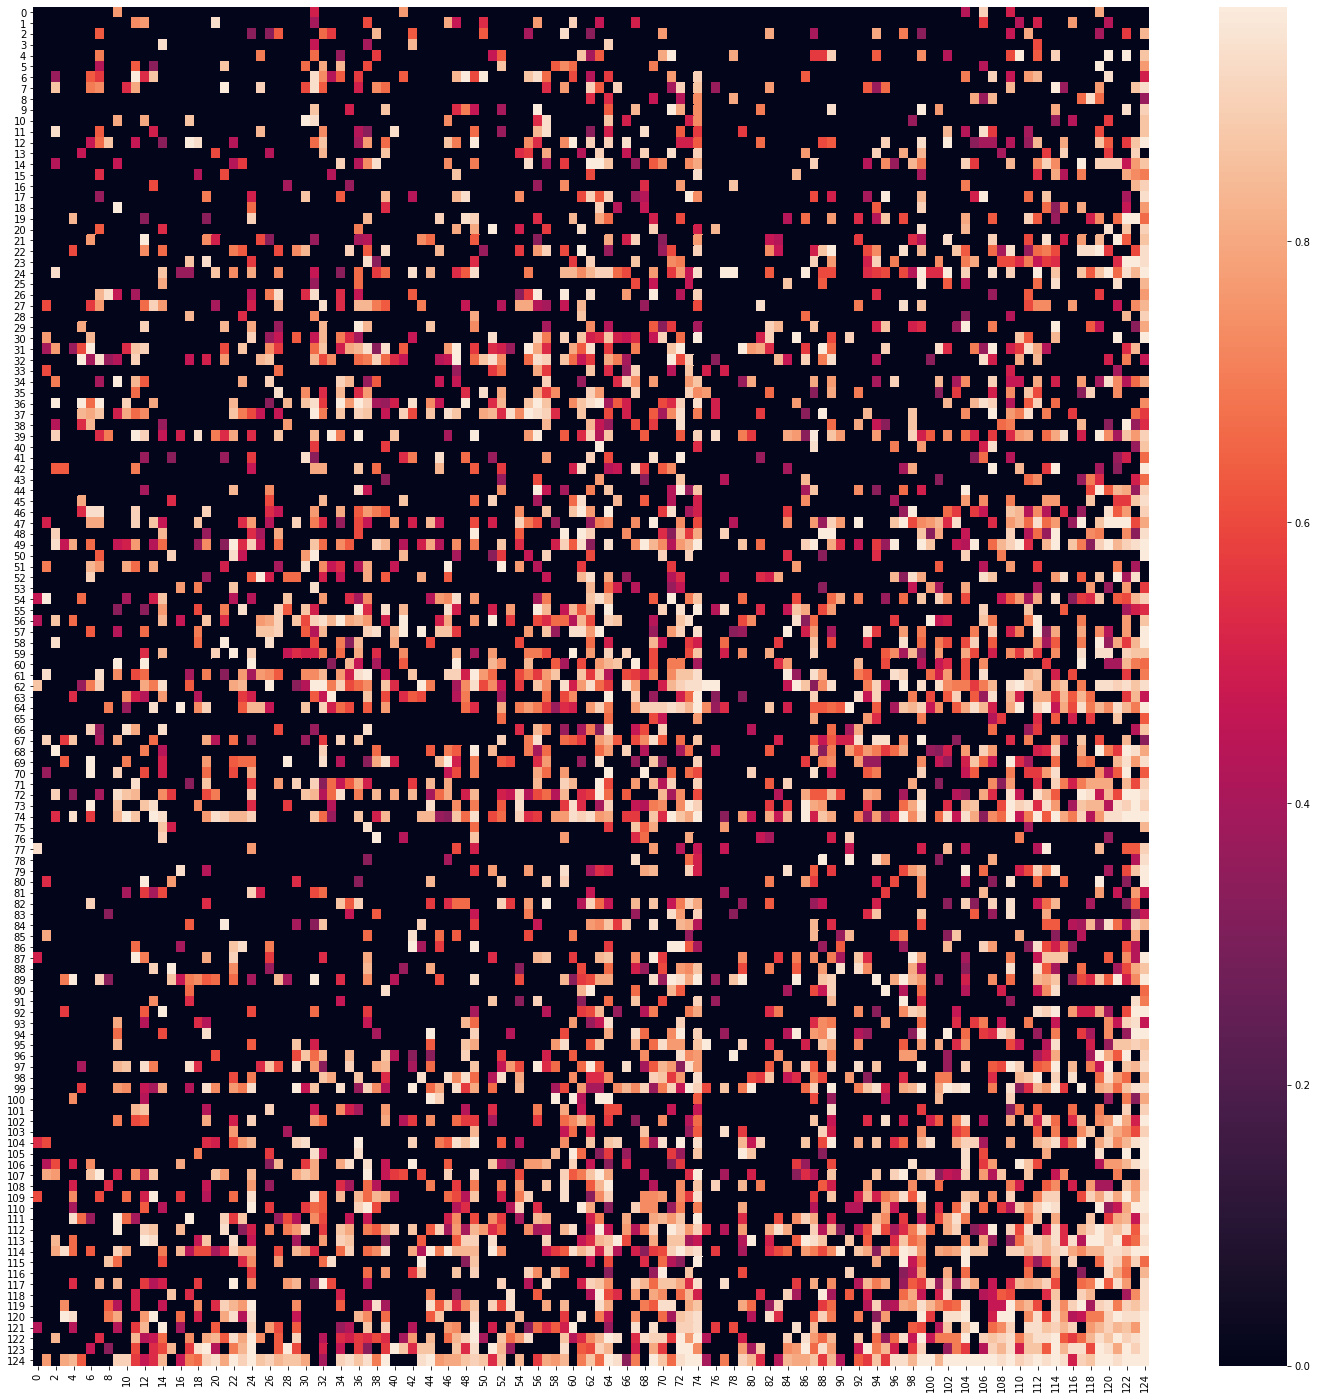

In [68]:
plt.figure(figsize=(25,25))
heat_map = sns.heatmap(Perf/15)

In [34]:
import random
n = len(np.arange(0, 1, 0.05))
X_controller = random.randint(0, n**24)
X_controller
#print(n)

13294579551095267387971857432949

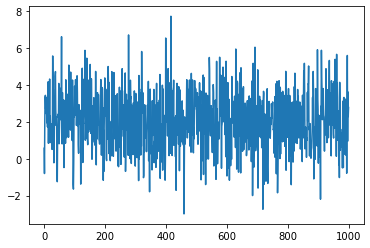

In [41]:
p = 1.5 * np.random.randn(1000) + 2 
plt.plot(p)

0.1515872813268513

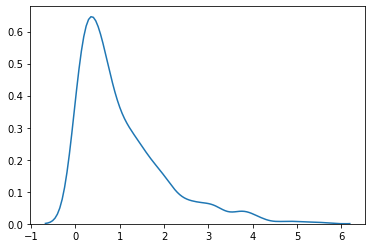

In [47]:
sns.distplot(np.random.exponential(size=1000), hist=False)
p = np.random.exponential(size=1000)
p[50]

In [70]:
import matplotlib

Perf /= 15

cmap = plt.cm.get_cmap("rocket")
norm = matplotlib.colors.Normalize()

gridspec_kw = {"height_ratios":[25, 25, 25, 25, 25], "width_ratios" : [25, 25, 25, 25, 25]}
heatmapkws = dict(square=True, cbar=False, linewidths=1.0) 
tickskw =  dict(xticklabels=False, yticklabels=False)


fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(125, 125), gridspec_kw=gridspec_kw)
#axes
#plt.subplots_adjust(left=left, right=right,bottom=bottom, top=top, wspace=0.1, hspace=0.1*asp )
sns.heatmap(Perf[:25,0:25], ax=axes[0,0], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[:25,25:50], ax=axes[0,1], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[:25,50:75], ax=axes[0,2],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[:25,75:100], ax=axes[0,3],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[:25,100:125], ax=axes[0,4],xticklabels=False, yticklabels=False, **heatmapkws)

sns.heatmap(Perf[25:50,0:25], ax=axes[1,0], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[25:50,25:50], ax=axes[1,1], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[25:50,50:75], ax=axes[1,2],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[25:50,75:100], ax=axes[1,3],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[25:50,100:125], ax=axes[1,4],xticklabels=False, yticklabels=False, **heatmapkws)

sns.heatmap(Perf[50:75,0:25], ax=axes[2,0], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[50:75,25:50], ax=axes[2,1], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[50:75,50:75], ax=axes[2,2],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[50:75,75:100], ax=axes[2,3],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[50:75,100:125], ax=axes[2,4],xticklabels=False, yticklabels=False, **heatmapkws)

sns.heatmap(Perf[75:100,0:25], ax=axes[3,0], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[75:100,25:50], ax=axes[3,1], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[75:100,50:75], ax=axes[3,2],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[75:100,75:100], ax=axes[3,3],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[75:100,100:125], ax=axes[3,4],xticklabels=False, yticklabels=False, **heatmapkws)

sns.heatmap(Perf[100:125,0:25], ax=axes[4,0], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[100:125,25:50], ax=axes[4,1], xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[100:125,50:75], ax=axes[4,2],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[100:125,75:100], ax=axes[4,3],xticklabels=False, yticklabels=False, **heatmapkws)
sns.heatmap(Perf[100:125,100:125], ax=axes[4,4],xticklabels=False, yticklabels=False, **heatmapkws)


axes[0,0].set_yticklabels([0, 25])
axes[1,0].set_xticklabels([25, 50])
#axes[1,2].set_xticklabels([9,10,11])

cax = fig.add_axes([0.9,0.1,0.03,0.8])
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm,cax=cax)

plt.show()